In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import os
import sys

os.chdir("C:/Users/user/Victor/Trabajo/ExtremeCorrection/")
sys.path.append(os.path.abspath('C:/Users/user/Victor/Trabajo/ExtremeCorrection/src'))

# Illustrative example

In this notebook the Illustrative example of paper "Point-in-time and extreme-value probability simulation technique for engineering design" R. Mínguez et al. (2012) is used to check the new Extreme Correction technique.

The example generates an ARMA process to generate the historical data and then correct a new simulated data.

## Generate Historical data with ARMA 

The ARMA(1,1) is generated with parameters $\phi_1 = -0.8$, $\theta_1 = 0.3$ and variance $\sigma_{\epsilon}^2 = 1$.

In [2]:
# Define ARMA parameters
phi_1 = -0.8
theta_1 = 0.3
sigma_eps = 1.0

In [3]:
sigma_z = np.sqrt((1+theta_1**2-2*phi_1*theta_1)/(1-phi_1**2)*sigma_eps**2)
sigma_z

2.0883273476902784

In [4]:
np.random.seed(42)  # For reproducibility

ar = np.array([1, phi_1])      
ma = np.array([1, theta_1])

n_hist = int(100*24*365.25)
# Define the ARMA process
arma_process = ArmaProcess(ar, ma)

hist_sample = arma_process.generate_sample(nsample=n_hist, scale=sigma_eps)

In [5]:
hist_sample

array([ 0.49671415,  0.40812127,  0.93270626, ..., -1.07623159,
       -0.69985485, -0.48101119])

In [6]:
# Starting date within the safe pandas timestamp range
start_date = '2000-01-01 00:00:00'

# Generate date range in 100 years chunks
date_range = pd.date_range(start=start_date, periods=n_hist, freq=f'h')  

In [7]:
date_range.year

Index([2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000,
       ...
       2099, 2099, 2099, 2099, 2099, 2099, 2099, 2099, 2099, 2099],
      dtype='int32', length=876600)

In [8]:
df_hs = pd.DataFrame({
    'time': date_range,
    'x': hist_sample,
    'yyyy': date_range.year,
    'mm': date_range.month,
    'dd': date_range.day,
    'hh': date_range.hour
})

df_hs.head()

,time,x,yyyy,mm,dd,hh
0,2000-01-01 00:00:00,0.496714,2000,1,1,0
1,2000-01-01 01:00:00,0.408121,2000,1,1,1
2,2000-01-01 02:00:00,0.932706,2000,1,1,2
3,2000-01-01 03:00:00,2.463501,2000,1,1,3
4,2000-01-01 04:00:00,2.193557,2000,1,1,4


## Generate Simulated Data

If data was previously simulated, load the data and do not run the following code

In [9]:
# df_sim = pd.read_csv("Data/IllExample/df_sim_gaussmix_200y.csv")
# df_sim['time'] = pd.to_datetime(df_sim['time'])

In [10]:
from src.arma_sim import ArmaSimulation

arma = ArmaSimulation(df_hs, var='x', freq=24*365.25, arma_order=(1,0,1), distribution="norm")#, n_components=4)
ny_sim = 1000
hs_sim = arma.generate_sim(ny_sim = ny_sim)   # We select the number of years of simulations

In [11]:
arma.params

(-0.004415753476777863, 2.0877039093020984)

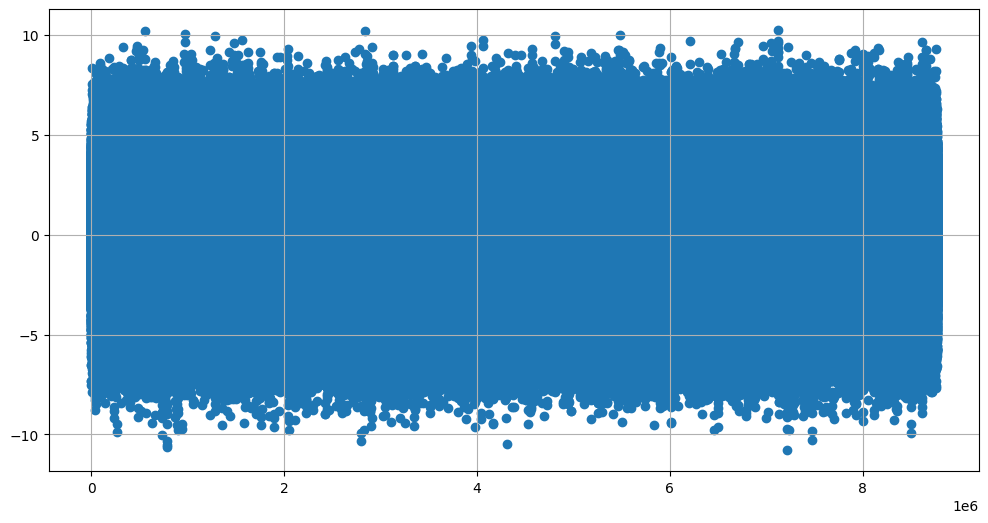

In [12]:
plt.figure(figsize=(12,6))
plt.scatter(np.arange(0,int(ny_sim*24*365.25)), hs_sim)
# plt.xticks(np.arange(200)*24*365.25)
plt.grid()
plt.show()

In [13]:
# Starting date within the safe pandas timestamp range
start_date = '2000-01-01 00:00:00'

# Generate date range in 100 years chunks
date_range = pd.date_range(start=start_date, periods=int(100*365.25*24), freq=f'h')  

In [14]:
import xarray as xr

date_range = xr.date_range(start_date, periods=int(1000*365.25*24), freq=f'H', use_cftime=True)

In [15]:
year_simulated = np.array([], dtype=np.int32)
month_simulated = np.array([], dtype=np.int32)
day_simulated = np.array([], dtype=np.int32)
hour_simulated = np.array([], dtype=np.int32)
for i in range(len(hs_sim)//len(date_range)):
    year_simulated = np.concatenate([year_simulated, date_range.year + 100*i])
    month_simulated = np.concatenate([month_simulated, date_range.month])
    day_simulated = np.concatenate([day_simulated, date_range.day])
    hour_simulated = np.concatenate([hour_simulated, date_range.hour])


df_sim = pd.DataFrame({
    'time': date_range,
    'yyyy': year_simulated,
    'mm':  month_simulated,
    'dd': day_simulated,
    'hh': hour_simulated,
    'x': hs_sim
})

In [16]:
df_sim.head()

,time,yyyy,mm,dd,hh,x
0,2000-01-01 00:00:00,2000,1,1,0,0.127317
1,2000-01-01 01:00:00,2000,1,1,1,0.738259
2,2000-01-01 02:00:00,2000,1,1,2,1.860894
3,2000-01-01 03:00:00,2000,1,1,3,1.391281
4,2000-01-01 04:00:00,2000,1,1,4,1.616667


In [17]:
# Comprobar que no hay datos del año 3000 (sin cambiar esto tenemos datos de 1001 años en vez de los 1000 que queremos)
df_sim = df_sim.iloc[:int(1000*365.243*24),:]

In [18]:
df_sim.to_csv("Data/IllExample/df_sim_IllExample_1000y.csv", index=False)

## General correction

In [19]:
df_sim.head()

,time,yyyy,mm,dd,hh,x
0,2000-01-01 00:00:00,2000,1,1,0,0.127317
1,2000-01-01 01:00:00,2000,1,1,1,0.738259
2,2000-01-01 02:00:00,2000,1,1,2,1.860894
3,2000-01-01 03:00:00,2000,1,1,3,1.391281
4,2000-01-01 04:00:00,2000,1,1,4,1.616667


In [20]:
from src.extremecorrection import ExtremeCorrection

config = {
    'var': 'x',
    'time_var': 'time',
    'yyyy_var': 'yyyy',
    'mm_var': 'mm',
    'dd_var': 'dd',
    'freq': 365.25*24,
    'folder': 'Figures/General_IllExample_1000y'
}

pot_config = {
    'n0': 10,
    'min_peak_distance': 2*24,
    'init_threshold': 0.1,
    'siglevel': 0.01,
    'plot_flag': True
}

Initialize the correction

In [21]:
extr_corr = ExtremeCorrection(
    data_hist = df_hs,
    data_sim = df_sim,
    config = config,
    pot_config = pot_config,
    method = "POT",
    conf_level = 0.95,
    tolerance = 0.8
)

Poisson parameters difference: 1.043771043771045


### Apply historical correction

In [22]:
extr_corr.apply_correction(fit_diag=True)   # fit_diag = True, to plot the diagnostics plots (QQ-Plot and PP-plot)
extr_corr.return_period_plot()              # Default to plot only the no corrected data 

C:\Users\user\Victor\Trabajo\ExtremeCorrection\src\extremecorrection.py:562: RuntimeWarning: invalid value encountered in sqrt
  stdDq_gpd = np.sqrt(np.sum((dqgpd.T@invI0_gpd) * dqgpd.T, axis=1))


In [23]:
extr_corr.parameters    # If GEV method, shape parameter has changed the sign

[4.46954809534815, 1.1397251987542814, -0.21762305459532888]

In [24]:
extr_corr.poiss_parameter

45.525252525252526

In [25]:
extr_corr.sim_poiss_parameter

44.48148148148148

### Apply simulated correction

In [26]:
extr_corr.apply_sim_correction()   # Apply the correction in the simulated data
extr_corr.sim_return_period_plot()                        # Default to plot the corrected and no corrected data
extr_corr.interval_return_period_plot(alpha=0.5)               # Comparative of no corrected vs corrected simulated data in the historical range
# extr_corr.time_series_plot(sim=False)                     # Time series of both corrected and no-corrected data

C:\Users\user\Victor\Trabajo\ExtremeCorrection\src\extremecorrection.py:865: RuntimeWarning: invalid value encountered in sqrt
  stdDq_gpd_sim = np.sqrt(np.sum((dqgpd_sim.T@invI0_gpd_sim) * dqgpd_sim.T, axis=1)) # Es lo mismo


Dataframe with the corrected simulation

In [26]:
new_sim_data = extr_corr.sim_pit_data_corrected
new_df_sim = df_sim.copy()
new_df_sim['x'] = new_sim_data

In [28]:
new_df_sim.to_csv("Data/IllExample/df_sim_IllExample_1000y_corr.csv")